In [16]:
# Gerekli kütüphaneleri içe aktarıyoruz.(Gözden kaçan kütüphaneler)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import MinMaxScaler 
import os 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
from sklearn.metrics import classification_report, confusion_matrix 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D 
from keras import backend as K 
from tensorflow.keras.utils import to_categorical 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix 
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers as keras_optimizers
from tensorflow.keras import models, layers, Input
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#ignore hata mesajı için ekliyoruz 
import warnings
warnings.filterwarnings('ignore')

sns.set();

### **1. Veri Setini Yükleme ve Keşfetme**

In [3]:
#Kaggle Üzerinden "A_Z Handwritten Data" Verisini Yükleme ve İlk İnceleme
dataset = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv").astype('float32')
dataset.rename(columns={'0':'label'}, inplace=True)

# X bağımsız değişken olarak ve y bağımlı değişken olarak atıyoruz. 
X = dataset.drop('label', axis=1)
y = dataset['label']

### **Keşfetme**

In [4]:
# Veri seti hakkında bilgi edinmeye çalışıyoruz.
print("X değişkeni şekli:",X.shape)
print("sütun sayısı:",len(X.iloc[1]))
print("784= 28*28")

X.head()

X değişkeni şekli: (372450, 784)
sütun sayısı: 784
784= 28*28


,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


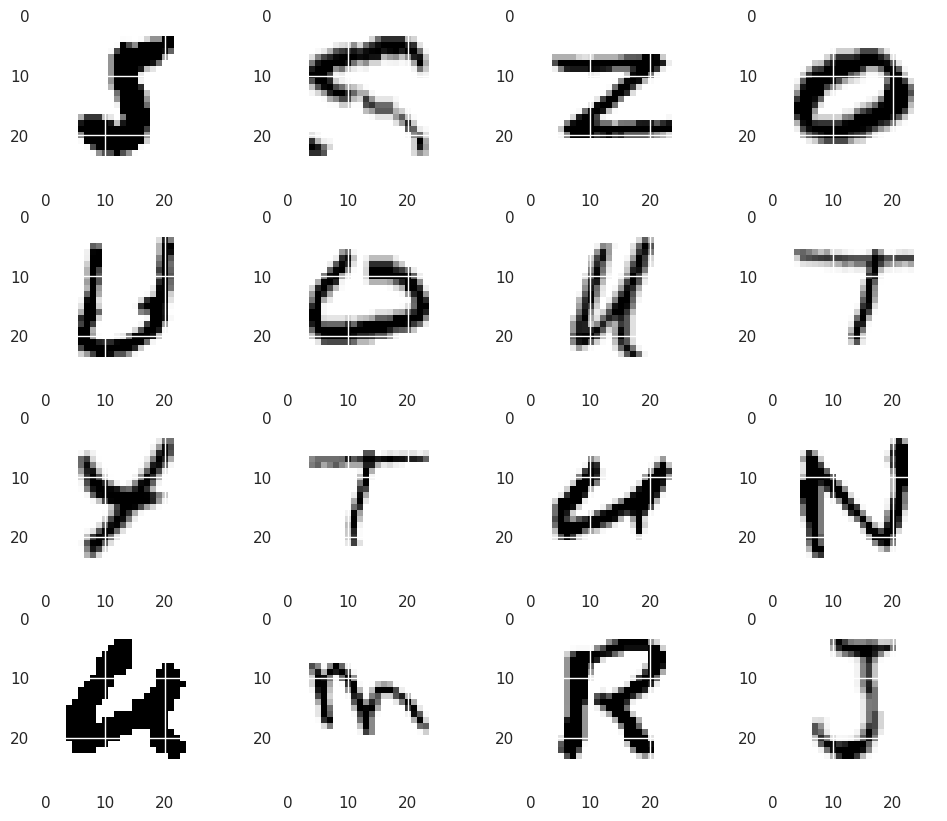

In [7]:
# İlk 16 örneğimizi görselleştiriyoruz 
X_shuffle = shuffle(X) 

plt.figure(figsize = (12,10)) 
row, colums = 4, 4 
for i in range(16): 
    plt.subplot(colums, row, i+1) 
    plt.imshow(X_shuffle.iloc[i].values.reshape(28,28),
           interpolation='nearest', 
           cmap='Greys') 

plt.show()

Her etiketin miktarı


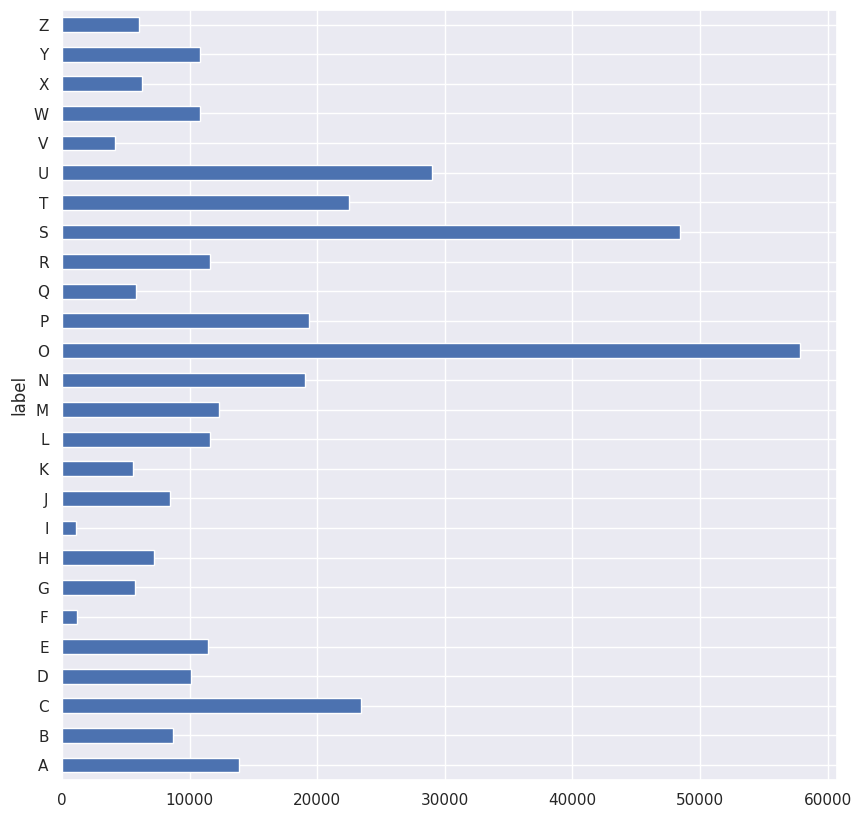

I ve F harflerinde çok düşük gözlemlerimiz var
I'nın sayısı: 1120
F'nin sayısı: 1163


In [8]:
print("Her etiketin miktarı")

# Etiketleri alfabetik harfler ile değiştiriyoruz. 
alphabets_mapper = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z'} 
dataset_alphabets = dataset.copy()
dataset['label'] = dataset['label'].map(alphabets_mapper)

#Etiketlerin ne kadar gözlemi var diye bakıyoruz.
label_size = dataset.groupby('label').size()
label_size.plot.barh(figsize=(10,10))
plt.show()

print("I ve F harflerinde çok düşük gözlemlerimiz var")
print("I'nın sayısı:", label_size['I'])
print("F'nin sayısı:", label_size['F'])

### **2. Veri Ön İşleme**

In [9]:
#Train/Test Split  kütüphanesi kullanıp verilerimizi train ve test olarak ayırıyoruz. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Verileri MinMaxScaler ölçeklendiricisi olarak ölçeklendiriyoruz.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Ölçeklendirme sonrası verileri gözlemliyoruz


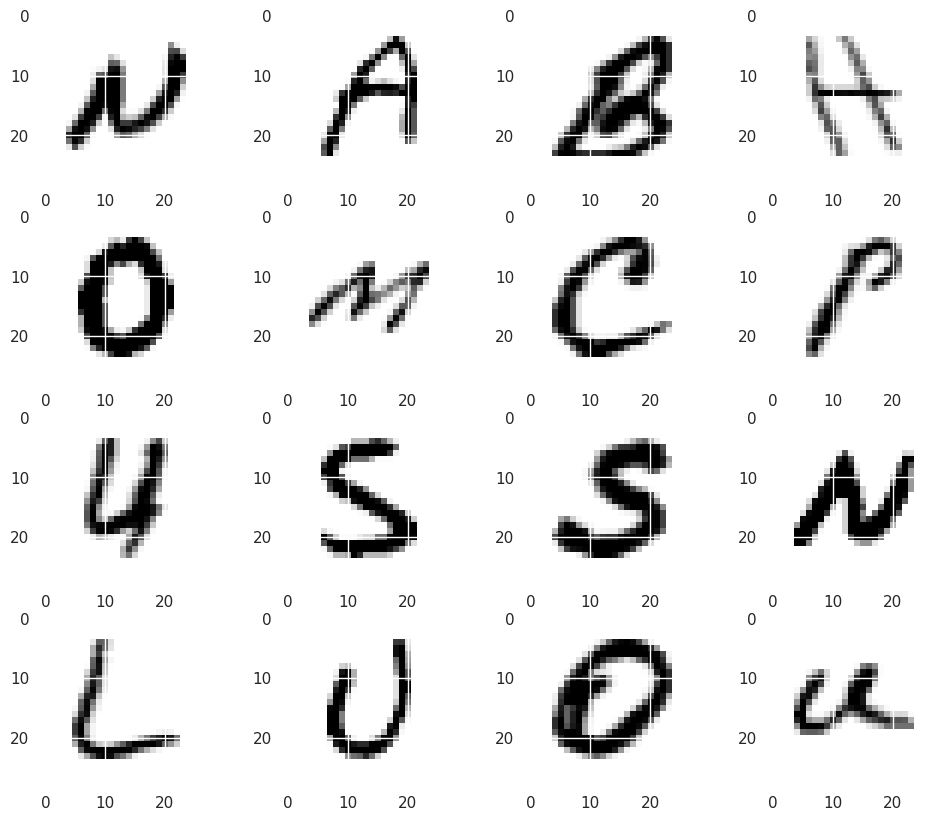

In [10]:
print("Ölçeklendirme sonrası verileri gözlemliyoruz")
X_shuffle = shuffle(X_train)

plt.figure(figsize = (12,10))
row, colums = 4, 4
for i in range(16):  
    plt.subplot(colums, row, i+1)
    plt.imshow(X_shuffle[i].reshape(28,28),interpolation='nearest', cmap='Greys')
plt.show()

In [11]:
#CNN modeli için uygun olsun diye tekrar şekillendiriyoruz.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

#One-Hot Encoding 26 görseli tanıyabilmek için ve sınıflandırmaya uyumlu olması için yapıyoruz. 
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Veri artırma için ImageDataGenerator kullanıyoruz
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)

### **3. Model Oluşturma**

In [14]:
#En iyi sonucu veren model yapısını bulmaya çalışıyoruz.
cnn_model = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(26, activation='softmax')
])

cls_deneme = Sequential()
cls_deneme.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
cls_deneme.add(MaxPooling2D(pool_size=(2, 2)))
cls_deneme.add(Dropout(0.5)) # Dropout oranını artırdık (Regülarizasyon için)

# İkinci bir Evrişim/Pooling katmanı ekliyoruz (Katman sayısı denemesi)
cls_deneme.add(Conv2D(128, (3, 3), activation='relu'))
cls_deneme.add(MaxPooling2D(pool_size=(2, 2)))
cls_deneme.add(Dropout(0.3))

cls_deneme.add(Flatten())
cls_deneme.add(Dense(256, activation='relu')) # Dense Layer boyutunu artırdık
cls_deneme.add(Dense(len(y.unique()), activation='softmax'));


### **4. Modeli Derleme ve Eğitme**

In [17]:
#Modelimizi Derliyoruz
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Optimizer'ı 'adam' yerine 'rmsprop' olarak değiştiriyoruz (Optimizer seçimi denemesi)
cls_deneme.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
scores = cnn_model.evaluate(X_test,y_test, verbose=0)

# Callback'leri tanımlayalım (erken durdurma ve öğrenme oranı ayarlama)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4);

print("CNN Skoru:",scores[1]);

CNN Skoru: 0.083004429936409


In [18]:
#Modelimizi Eğitiyoruz
history_cnn = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                            validation_data=(X_test, y_test),
                            epochs=20,
                            callbacks=[early_stopping, reduce_lr],
                            verbose=2)

# Modeli Eğitme (Aynı veri ve callback'ler ile)
print("Model Deneme 2 Eğitimi Başlıyor (rmsprop, Daha Derin)")
history_deneme = cls_deneme.fit(
    datagen.flow(X_train, y_train, batch_size=200),
    validation_data=(X_test, y_test),
    epochs=18,
    callbacks=[early_stopping, reduce_lr], # Aynı callback'leri kullanıyoruz
    verbose=2)



    # Sonuçları Değerlendirme
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Temel CNN Test Doğruluğu: {test_acc_cnn:.3f}")

Epoch 1/20
4656/4656 - 104s - 22ms/step - accuracy: 0.8301 - loss: 0.5695 - val_accuracy: 0.9413 - val_loss: 0.2034 - learning_rate: 0.0010
Epoch 2/20
4656/4656 - 95s - 20ms/step - accuracy: 0.9145 - loss: 0.2870 - val_accuracy: 0.9482 - val_loss: 0.1794 - learning_rate: 0.0010
Epoch 3/20
4656/4656 - 94s - 20ms/step - accuracy: 0.9303 - loss: 0.2343 - val_accuracy: 0.9544 - val_loss: 0.1580 - learning_rate: 0.0010
Epoch 4/20
4656/4656 - 94s - 20ms/step - accuracy: 0.9383 - loss: 0.2087 - val_accuracy: 0.9608 - val_loss: 0.1394 - learning_rate: 0.0010
Epoch 5/20
4656/4656 - 94s - 20ms/step - accuracy: 0.9435 - loss: 0.1932 - val_accuracy: 0.9618 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 6/20
4656/4656 - 93s - 20ms/step - accuracy: 0.9463 - loss: 0.1817 - val_accuracy: 0.9610 - val_loss: 0.1345 - learning_rate: 0.0010
Epoch 7/20
4656/4656 - 98s - 21ms/step - accuracy: 0.9493 - loss: 0.1734 - val_accuracy: 0.9598 - val_loss: 0.1452 - learning_rate: 0.0010
Epoch 8/20
4656/4656 - 99s

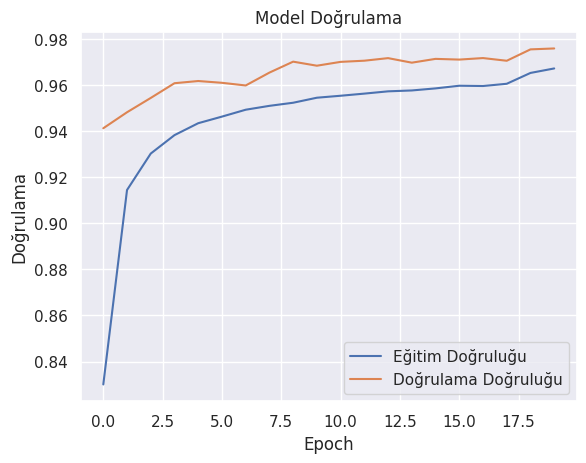

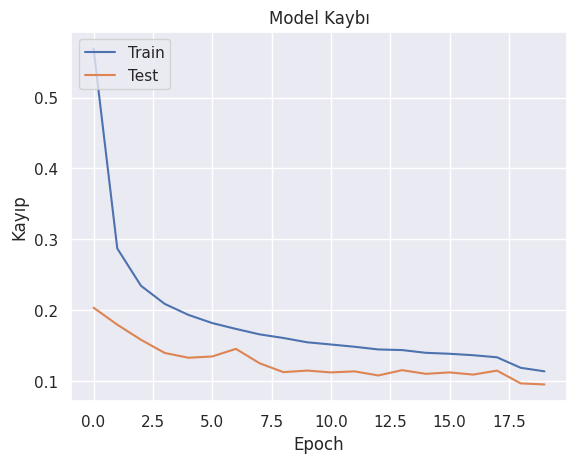

In [19]:
# Eğitim; doğrulama kaybı ve doğrulama doğruluğunu görselleştirelim
plt.plot(history_cnn.history['accuracy'], label= "Eğitim Doğruluğu ")
plt.plot(history_cnn.history['val_accuracy'], label= "Doğrulama Doğruluğu")
plt.title('Model Doğrulama')
plt.ylabel('Doğrulama')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history_cnn.history['loss'], label='Eğitim Kaybı')
plt.plot(history_cnn.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### **5. Model Değerlendirme**


Test kaybımız: 0.095
Test doğruluğu: 0.976

Model 2 Test Doğruluğu (cls_deneme): 0.983
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           A       0.97      0.99      0.98      2774
           B       0.95      0.97      0.96      1734
           C       0.98      0.98      0.98      4682
           D       0.94      0.93      0.93      2027
           E       0.98      0.97      0.98      2288
           F       0.96      0.98      0.97       233
           G       0.96      0.96      0.96      1152
           H       0.97      0.96      0.97      1444
           I       0.98      0.97      0.97       224
           J       0.91      0.92      0.91      1699
           K       0.97      0.95      0.96      1121
           L       0.96      0.96      0.96      2317
           M       0.98      0.99      0.99      2467
           N       0.97      0.95      0.96      3802
           O       0.99      0.99   

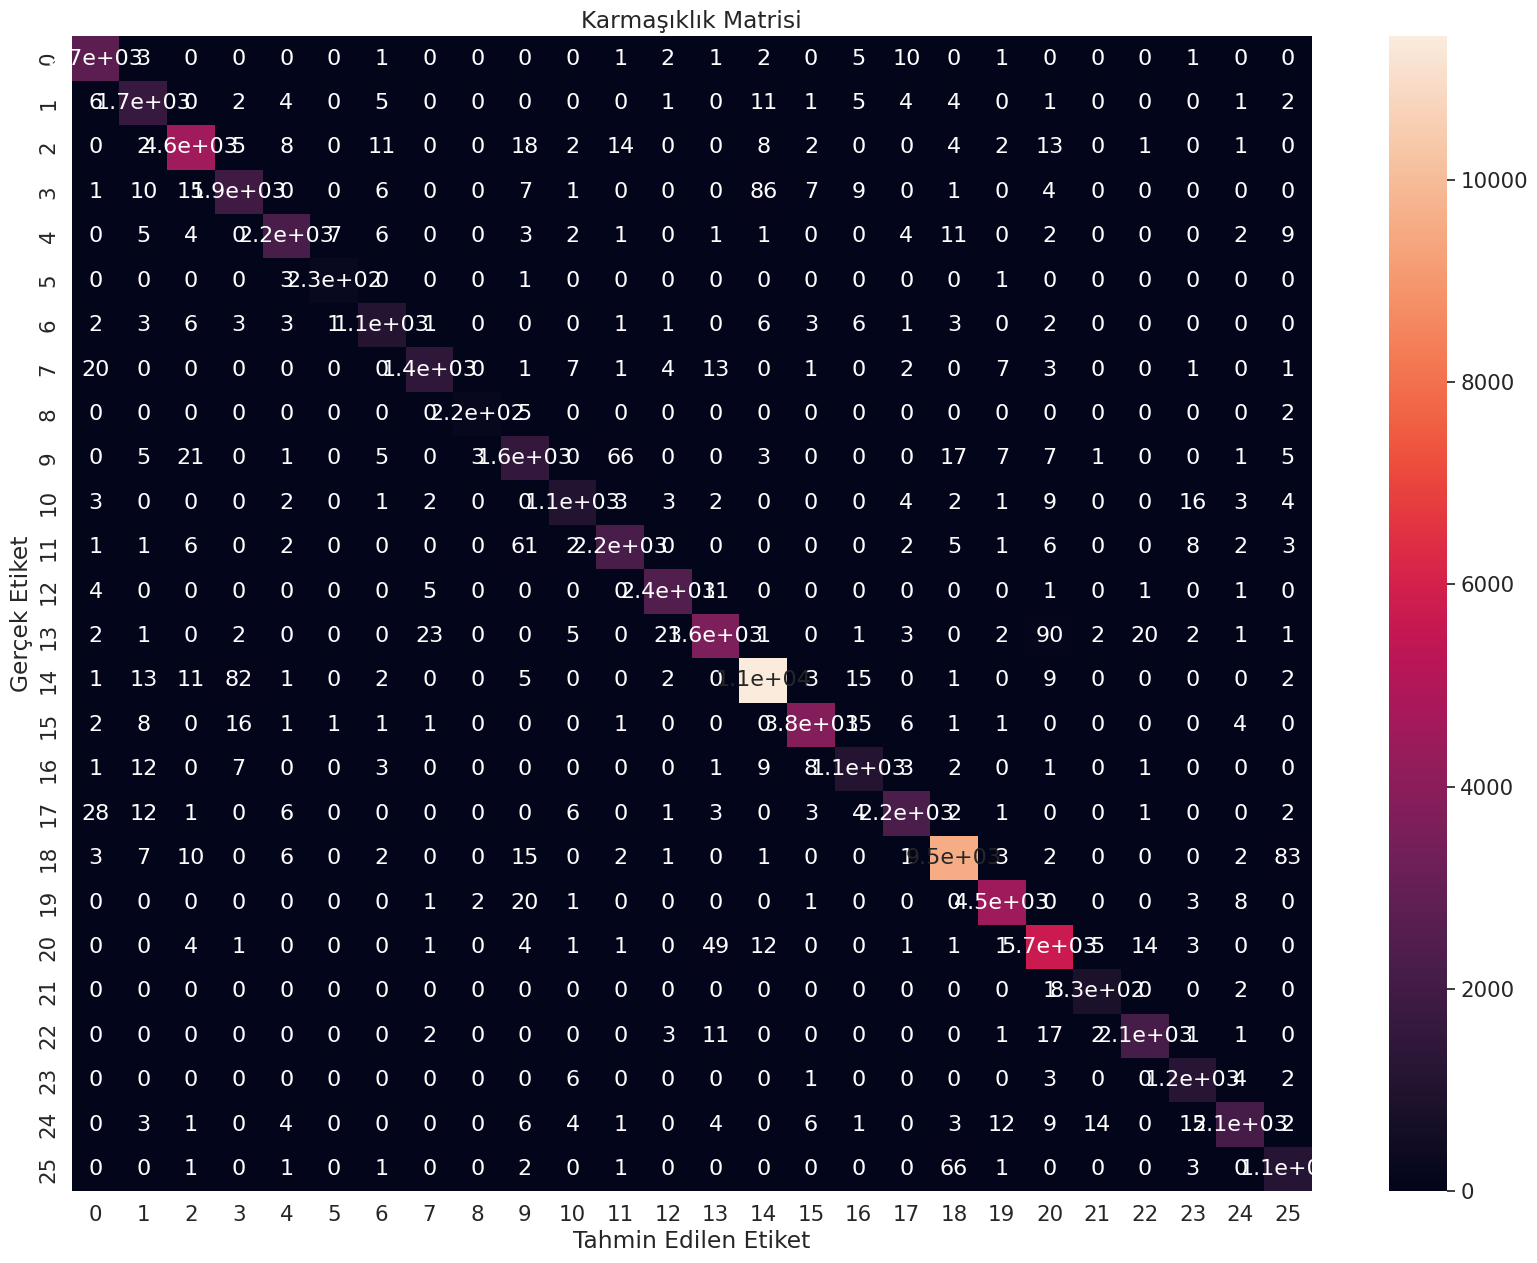

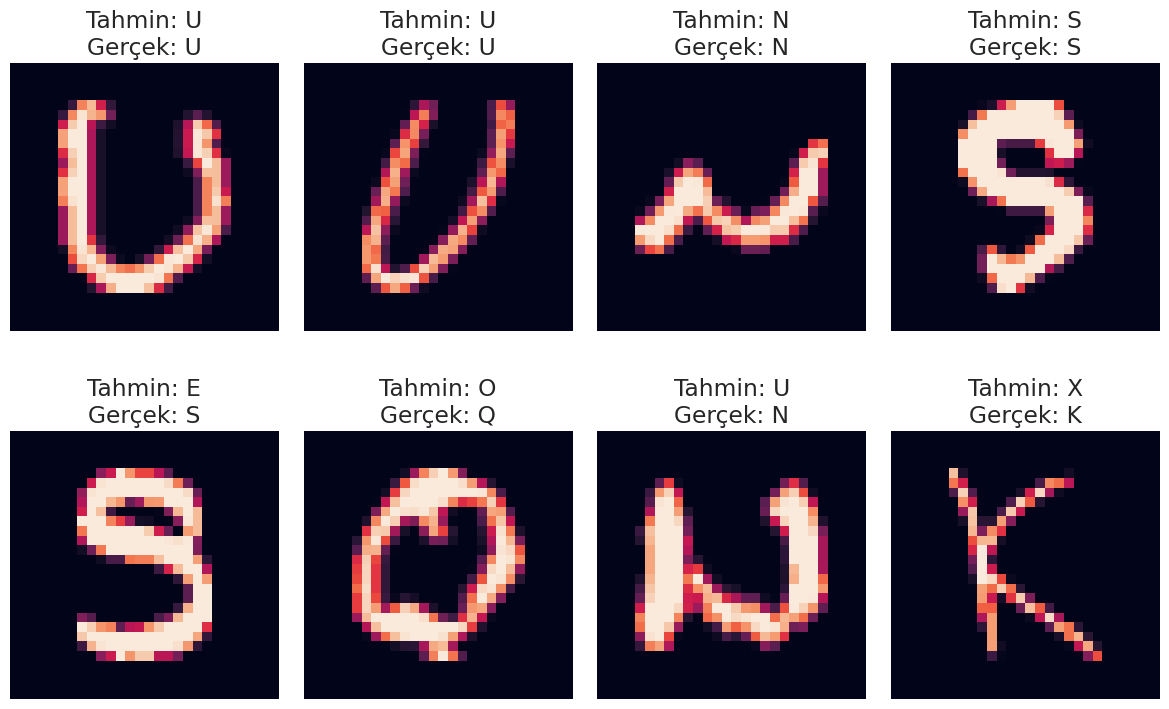

In [20]:
# Sonuçlarımızı değerlendiriyoruz ardından tahminde bulunucaz.
test_loss, test_accuracy= cnn_model.evaluate(X_test, y_test, verbose=0 )
print(f"Test kaybımız: {test_loss:.3f}\nTest doğruluğu: {test_accuracy:.3f}")

test_loss_deneme, test_accuracy_deneme = cls_deneme.evaluate(X_test, y_test, verbose=0)
print(f"\nModel 2 Test Doğruluğu (cls_deneme): {test_accuracy_deneme:.3f}")

# Tahminlerde bulunalım
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = ['A','B','C','D','E','F','G','H','I','J',
                'K','L','M','N','O','P','Q','R','S','T',
                'U','V','W','X','Y','Z']

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names= target_names ))


# Karmaşıklık matrisi
cm=confusion_matrix(y_test.argmax(axis=1),cnn_model.predict(X_test).argmax(axis=1))
df_cm = pd.DataFrame(cm, range(26),
                  range(26))
plt.figure(figsize = (20,15))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])
    plt.title(f"Tahmin: {target_names[y_pred_classes[correct]]}\nGerçek: {target_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {target_names[y_pred_classes[incorrect]]}\nGerçek: {target_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### **6. Transfer Learning**

In [21]:
# Giriş katmanını tanımlıyoruz
input_tensor = Input(shape=(28,28,1))


# Üstteki sınıflandırma katmanlarını dahil etmiyoruz.
x3 = layers.Conv2D(3, (3,3), padding='same')(input_tensor)  

base_model = MobileNetV2(input_tensor=x3, include_top=False, weights=None)

# Temel modelin katmanlarını donduralım (eğitimlerini engelleyelim)
for layer in base_model.layers:
    layer.trainable = False

# Yeni Sınıflandırma Katmanlarını Ekliyoruz 
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Çıkış katmanı (26 sınıf)
predictions = layers.Dense(26, activation='softmax')(x)

# Final modelini oluşturma
transfer_model = Model(inputs=input_tensor, outputs=predictions)


# Modeli derleyelim
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


transfer_model.summary()


# Modeli Eğitme 
print("\n MobileNetV2 Eğitimi Başlıyor ")
# Veri değişkenleriniz (X_train, y_train, X_test, y_test) doğrudan kullanılabilir
history_tl = transfer_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                validation_data=(X_test, y_test),
                                epochs=20,
                                callbacks=[early_stopping, reduce_lr],
                                verbose=2)

# Değerlendirme 
test_loss_tl, test_acc_tl = transfer_model.evaluate(X_test, y_test, verbose=0)
print(f"Transfer Learning Test Doğruluğu: {test_acc_tl:.4f}")


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 28, 3) │         30 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 14, 14,    │        864 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 14, 14,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 14, 14,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 14, 14,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 14, 14,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 14, 14,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 14, 14,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 14, 14,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 14, 14,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 14, 14,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 14, 14,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 15, 15,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 7, 7, 96)  │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 7, 7, 96)  │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 7, 7, 96)  │          0 │ block_1_depthwis… │
│ (ReLU)              │                   │            │                 

 Total params: 2,592,632 (9.89 MB)

 Trainable params: 334,618 (1.28 MB)

 Non-trainable params: 2,258,014 (8.61 MB)


 MobileNetV2 Eğitimi Başlıyor 
Epoch 1/20
4656/4656 - 136s - 29ms/step - accuracy: 0.1543 - loss: 2.9385 - val_accuracy: 0.1553 - val_loss: 2.9288 - learning_rate: 0.0010
Epoch 2/20
4656/4656 - 112s - 24ms/step - accuracy: 0.1553 - loss: 2.9323 - val_accuracy: 0.1553 - val_loss: 2.9296 - learning_rate: 0.0010
Epoch 3/20
4656/4656 - 111s - 24ms/step - accuracy: 0.1552 - loss: 2.9315 - val_accuracy: 0.1553 - val_loss: 2.9289 - learning_rate: 0.0010
Epoch 4/20
4656/4656 - 110s - 24ms/step - accuracy: 0.1553 - loss: 2.9310 - val_accuracy: 0.1553 - val_loss: 2.9290 - learning_rate: 0.0010
Epoch 5/20
4656/4656 - 110s - 24ms/step - accuracy: 0.1553 - loss: 2.9306 - val_accuracy: 0.1553 - val_loss: 2.9287 - learning_rate: 0.0010
Epoch 6/20
4656/4656 - 111s - 24ms/step - accuracy: 0.1553 - loss: 2.9302 - val_accuracy: 0.1553 - val_loss: 2.9288 - learning_rate: 0.0010
Epoch 7/20
4656/4656 - 112s - 24ms/step - accuracy: 0.1553 - loss: 2.9300 - val_accuracy: 0.1553 - val_loss: 2.9287 - learning_r

### **7. Veri Görselleştirme ve Model Karşılaştırması**

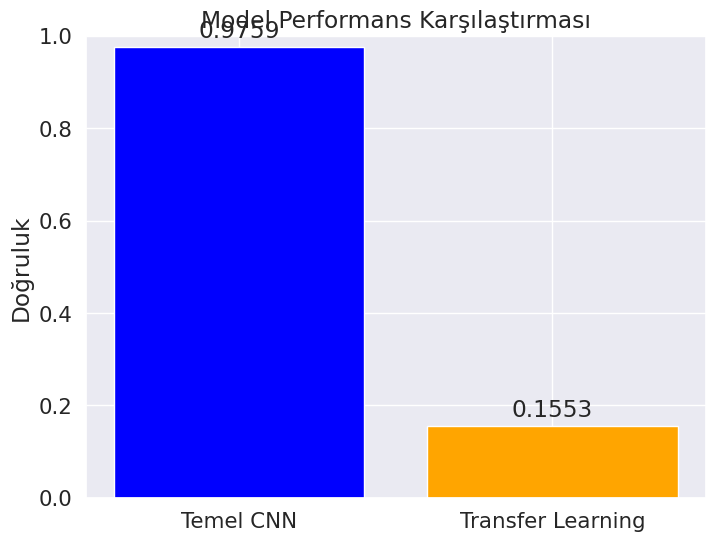

Bulunan Conv2D katmanları: ['conv2d_4', 'conv2d_5']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step


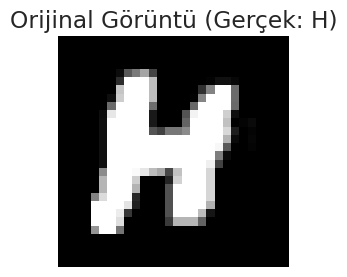

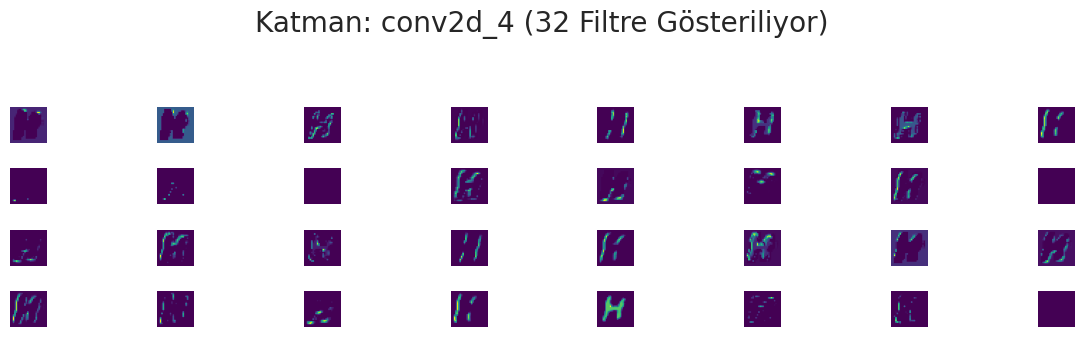

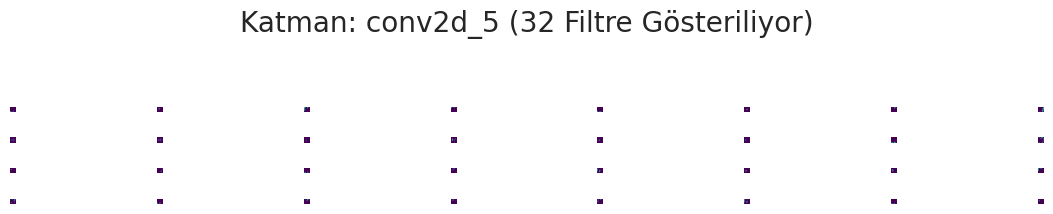

In [22]:
# Model performanslarını karşılaştıralım
model_names = ['Temel CNN', 'Transfer Learning']
accuracies = [test_accuracy, test_acc_tl]

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['blue', 'orange'])
plt.title('Model Performans Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')
plt.show()


#  DÜZELTİLMİŞ ÖZNİTELİK HARİTALARINI GÖRSELLEŞTİRME BÖLÜMÜ

cnn_model_to_analyze = cls_deneme # cls_deneme modelini kullanalım, çünkü daha iyi eğitilmiş olabilir

# Conv2D katmanlarının çıktılarını ve isimlerini doğrudan toplayalım
layer_outputs = []
layer_names = []

# cls_deneme modeli zaten Sequential olduğu için .output'a erişiyoruz
for layer in cnn_model_to_analyze.layers:
    if isinstance(layer, layers.Conv2D):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)

# Aktivasyon modeli, cnn_model_to_analyze'ın girişini ve Conv2D çıktılarını kullanır.
# cls_deneme için .inputs[0] ve .outputs'u kullanabiliriz.
activation_model = models.Model(
    inputs=cnn_model_to_analyze.inputs,
    outputs=layer_outputs
)

print(f"Bulunan Conv2D katmanları: {layer_names}")
# ----------------------------------------------------------------------

# Görselleştirmek istediğin test görüntüsü
img_index = 10
img_to_visualize = X_test[img_index]
# X_test zaten (N, 28, 28, 1) şeklinde olduğu için boyut kontrolü sadece bir ihtimale karşı
if len(img_to_visualize.shape) == 3:  
    img_to_visualize = np.expand_dims(img_to_visualize, 0)  # (1,28,28,1)

# Aktivasyonları hesapla 
try:
    activations = activation_model.predict(img_to_visualize)
except KeyError as e:
    print(f"\nBeklenen KeyError çözülmedi veya başka bir hata oluştu: {e}")
    print("Lütfen activation_model'in inputs ve outputs'unu tekrar kontrol edin.")
    exit() # Hata oluşursa görselleştirmeye devam etmemek için

# Orijinal görüntüyü göster
plt.figure(figsize=(3,3))
plt.imshow(img_to_visualize[0].reshape(28,28), cmap="gray")
plt.title("Orijinal Görüntü (Gerçek: {})".format(target_names[y_true[img_index]]))
plt.axis("off")
plt.show()

# Feature map'leri görselleştiriyoruz
for layer_name, layer_activation in zip(layer_names, activations):
    
    # layer_activation bir numpy array olmalı
    if isinstance(layer_activation, list):
        layer_activation = layer_activation[0]

    n_filters = layer_activation.shape[-1]
    n_cols = 8
    n_rows = n_filters // n_cols + (n_filters % n_cols > 0)

    # Maksimum 32 filtreyi gösterelim (daha hızlı görselleştirme için)
    max_filters_to_show = min(n_filters, 32)
    
    plt.figure(figsize=(n_cols*1.5, (max_filters_to_show // n_cols + (max_filters_to_show % n_cols > 0))*1.5 ))
    plt.suptitle(f"Katman: {layer_name} ({max_filters_to_show} Filtre Gösteriliyor)")

    for i in range(max_filters_to_show):
        plt.subplot(n_rows, n_cols, i+1)
        # Bazen çıktılar 4D yerine 3D olabilir, reshape kontrolü ekleyelim
        if layer_activation.ndim == 4:
             plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        else: # Örneğin GlobalPooling sonrası 2D çıktı
             plt.imshow(layer_activation[:, i], cmap='viridis')
             
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### **8. Model İyileştirme Teknikleri**


--- Adam optimizer ile eğitim başlıyor ---
Adam Test Doğruluğu: 0.9951 (Epochs: 15)

--- RMSprop optimizer ile eğitim başlıyor ---
RMSprop Test Doğruluğu: 0.9941 (Epochs: 15)

--- SGD_Momentum optimizer ile eğitim başlıyor ---
SGD_Momentum Test Doğruluğu: 0.9925 (Epochs: 15)


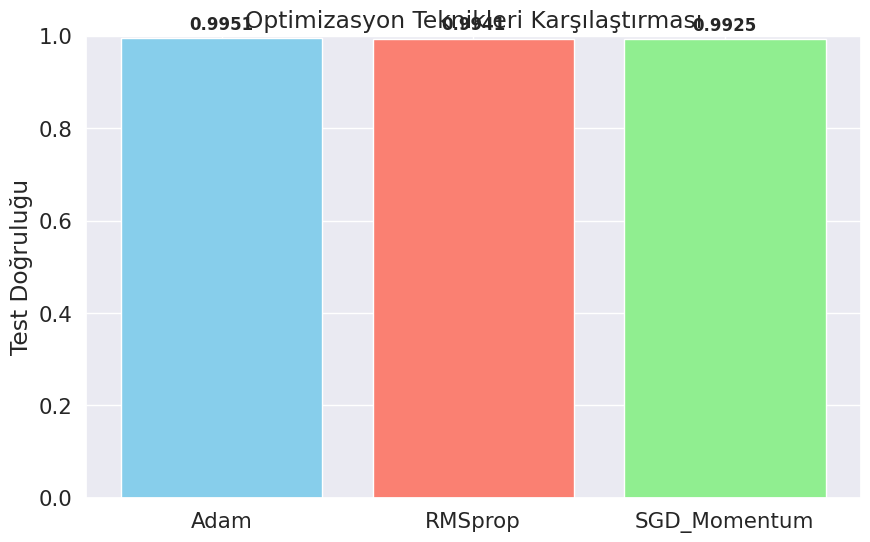

In [23]:
# 1. Model Yapısını Tanımlayan Fonksiyon (cls_deneme yapısını kullanıyoruz)
def create_optim_model():
    """cls_deneme modelinin yapısını oluşturur."""
    model = Sequential()
    model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) 

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu')) 
    # y.unique() sayısı 26'dır.
    model.add(Dense(26, activation='softmax'))
    return model

# 2. Farklı optimizasyon tekniklerini tanımlayalım
optimizers = {
    'Adam': keras_optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras_optimizers.RMSprop(learning_rate=0.001),
    # SGD için genellikle daha yüksek bir öğrenme oranı ve momentum kullanmamız daha iyidir
    'SGD_Momentum': keras_optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}
epochs_to_run = 15 # Karşılaştırma için sabit bir epoch sayısı belirleyelim
batch_size_val = 128 # Hızlı deneme için uygun bir batch boyutu

# 3. Her optimizasyon tekniği ile modeli eğitme ve değerlendirme
for opt_name, optimizer in optimizers.items():
    print(f"\n--- {opt_name} optimizer ile eğitim başlıyor ---")

    # Modeli her seferinde yeniden oluşturuyoruz
    model = create_optim_model() 
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Sizin notebook'unuzdaki X_train ve y_train değişkenleri kullanıldı.
    history = model.fit(X_train, y_train, # y_train zaten kategorik (to_categorical yapılmıştı)
                        epochs=epochs_to_run,
                        batch_size=batch_size_val,
                        validation_data=(X_test, y_test),
                        verbose=0) # Çıktıyı temiz tutmak için verbose=0

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f} (Epochs: {epochs_to_run})")

# 4. Optimizasyon tekniklerini görsel olarak karşılaştıralım
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Optimizasyon Teknikleri Karşılaştırması')
plt.ylabel('Test Doğruluğu')
plt.ylim(0, 1.0) # Doğruluğu 0 ile 1 arasında gösterelim

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

plt.show()

In [24]:
# Projenin sonunda nihai sonuçları yazdırma
print("=" * 50)
print("HANDWRİTTEN ALPHABETS PROJE SONUÇLARI")
print("=" * 50)

# Temel CNN Model Doğruluğu
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")

# Transfer Learning Model Doğruluğu
print(f"Transfer Learning Model Doğruluğu: {test_acc_tl:.4f}")

# En iyi optimizer'ı bulma
best_optimizer_name = max(results, key=results.get)
best_optimizer_accuracy = results[best_optimizer_name]

print(f"En iyi optimizer: {best_optimizer_name} ({best_optimizer_accuracy:.4f})")
print("=" * 50)

HANDWRİTTEN ALPHABETS PROJE SONUÇLARI
Temel CNN Model Doğruluğu: 0.9759
Transfer Learning Model Doğruluğu: 0.1553
En iyi optimizer: Adam (0.9951)
